In [1]:
print(0)

0


In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

In [308]:
class Config:
    DATA_PATH = Path("./data/imdb_indonesian_movies_2.csv")
    PICKLE_PATH =  Path("./pickle")
    FEATURES = ["judul_film", "ringkasan_sinopsis"]
    LABEL = "genre"
    
class Metric:
    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
    
    def precision(self, y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        return tp / (tp + fp)
    
    def recall(self, y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        return tp / (tp + fn)
    
    def f1_score(self, y_true, y_pred):
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * precision * recall / (precision + recall)
    
    def classification_metrics(self, y_true, y_pred):
        accuracy = self.accuracy(y_true, y_pred)
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(y_true, y_pred)
        return accuracy, precision, recall, f1_score


class KFold:
    def __init__(self, n_splits=5, shuffle=True):
        self.n_splits = n_splits
        self.shuffle = shuffle
    
    def split(self, X):
        n = len(X)
        idx = np.arange(n)
        
        if self.shuffle:
            np.random.shuffle(idx)
        
        for i in range(self.n_splits):
            start = i * n // self.n_splits
            end = (i + 1) * n // self.n_splits
            val_idx = idx[start:end]
            train_idx = np.delete(idx, val_idx)
            yield train_idx, val_idx


class MKNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # def _euclidean_distance(self, x1, x2):
    #     return 1 - spatial.distance.cosine(x1, x2)
    
    def _cosine_similarity(self, x1, x2):
        return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

    def _S(self, a, b):
        return 1 if a == b else 0
    
    def _validity_score(self, i):
        distances = np.array([self._cosine_similarity(self.X_train[i], x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        return 1 / self.k * np.sum([self._S(self.y_train[i], self.y_train[k]) for k in k_indices])
        
    def _predict(self, x_test):
        distances = np.array([self._cosine_similarity(x_test, x_train) for x_train in self.X_train])
        k_indices = np.argsort(distances)[:self.k]
        validity_scores = [self._validity_score(i) for i in k_indices]
        k_labels=  [self.y_train[i] for i in k_indices]

        W = [
            validity_scores[i] / (distances[k_indices[i]] + 0.0001) for i in range(len(k_indices))
        ]

        sum_w = Counter()
        for i in range(len(k_indices)):
            sum_w[k_labels[i]] += W[i]
        
        return sum_w.most_common(1)[0][0]
        
    def predict(self, X_test):
        return np.array([self._predict(x_test) for x_test in X_test])
    
class Tfidfvectorizer:
    def __init__(self, min_df=1):
        self.min_df = min_df
    
    def preprocess(self, docs):
        self.word_set = []
        self.kalimats = []
        
        for kalimat in docs:
            kalimat = [kata.lower() for kata in kalimat.split()]
            self.kalimats.append(kalimat)
            for kata in kalimat:
                if kata not in self.word_set:
                    self.word_set.append(kata)
        
        self.word_set = set(self.word_set)
        self.n_docs = len(self.kalimats)
        self.index_dict = {kata: i for i, kata in enumerate(self.word_set)}
        
        self.word_count = {}
        for kata in self.word_set:
            self.word_count[kata] = 0
            for kalimat in self.kalimats:
                if kata in kalimat:
                    self.word_count[kata] += 1


    def tf(self,docs, kata):
        n = len(docs)
        cocok = len([k for k in docs if k == kata])
        return cocok / n
    
    def idf(self,kata):
        try:
            kata_cocok = self.word_count[kata] + 1
        except:
            kata_cocok = 1
        
        return np.log(self.n_docs / kata_cocok)
    
    def tf_idf(self, kalimat):
        vec = np.zeros((len(self.word_set),))
        for kata in kalimat:
            tf = self.tf(kalimat, kata)
            idf = self.idf(kata)
            
            vec[self.index_dict[kata]] = tf * idf
        
        return vec

    def fit_transform(self, docs):
        self.preprocess(docs)
        vecs = []
        for kalimat in self.kalimats:
            vecs.append(self.tf_idf(kalimat))
        
        return np.array(vecs)


class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, p=2):
        predicted_labels = [self._predict(x, p) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x, p=2):
        distances = [self._distance(x, x_train, p) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _distance(self, x1, x2, p=2):
        return np.sum((x1 - x2) ** p) ** (1 / p)

    def score(self, X, y):
        predicted_labels = self.predict(X)
        return np.mean(predicted_labels == y)


In [309]:
data = pd.read_csv(Config.DATA_PATH)
data["genre"].value_counts()

genre
Drama       202
Laga        202
Komedi      201
Horor       200
Romantis    200
Name: count, dtype: int64

In [310]:
data = data[(data["genre"] == "Komedi") | (data["genre"] == "Laga")]

## Cleaning

In [311]:
import re

data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: x.lower())
data["ringkasan_sinopsis"] = data["ringkasan_sinopsis"].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data["judul_film"] = data["judul_film"].apply(lambda x: x.lower())
data["judul_film"] = data["judul_film"].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x))
data.head()

,judul_film,ringkasan_sinopsis,genre
402,warkop dki reborn jangkrik boss,dono abimana aryasatya kasino vino g bastian d...,Komedi
403,garuda 7 next mission,film ini menceritakan mengenai pemain sepakbol...,Komedi
404,si pitung,pitung bak koboi yang menyelesaikan satu masal...,Komedi
405,pangolin,pangolin adalah pandangan sekilas ke dalam per...,Komedi
406,hafiz friends recap s3,bercerita tentang pertualangan hafiz dan teman...,Komedi


## Training

In [312]:
kf = KFold(n_splits=5)

for train_idx, test_idx in kf.split(data[Config.FEATURES]):
    print(len(train_idx), len(test_idx))
    # print(data[Config.LABEL][train_idx].value_counts())
    break

323 80


In [326]:
t = Tfidfvectorizer()

X_ringkasan = t.fit_transform(data["ringkasan_sinopsis"])
X_judul = t.fit_transform(data["judul_film"])
y = np.array(data[Config.LABEL].replace({"Komedi": 0, "Laga": 1}))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

X = np.concatenate([X_ringkasan, X_judul], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
metric = Metric()
ks = range(2, 20)
mknn_f1_score_list = []
mknn_precision_list = []
mknn_recall_list = []
mknn_accuracy_list = []
knn_f1_score_list = []
knn_precision_list = []
knn_recall_list = []
knn_accuracy_list = []

for i in tqdm(ks):
    mk = MKNNClassifier(k=i)
    mk.fit(X_train, y_train)
    y_pred = mk.predict(X_test)
    
    kk = KNNClassifier(k=i)
    kk.fit(X_train, y_train)
    y_pred_knn = kk.predict(X_test)
    
    mknn_accuracy, mknn_precision, mknn_recall, mknn_f1_score = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
    knn_accuracy, knn_precision, knn_recall, knn_f1_score = accuracy_score(y_test, y_pred_knn), precision_score(y_test, y_pred_knn), recall_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn)

    
    mknn_f1_score_list.append(mknn_f1_score)
    mknn_precision_list.append(mknn_precision)
    mknn_recall_list.append(mknn_recall)
    mknn_accuracy_list.append(mknn_accuracy)
    
    knn_f1_score_list.append(knn_f1_score)
    knn_precision_list.append(knn_precision)
    knn_recall_list.append(knn_recall)
    knn_accuracy_list.append(knn_accuracy)

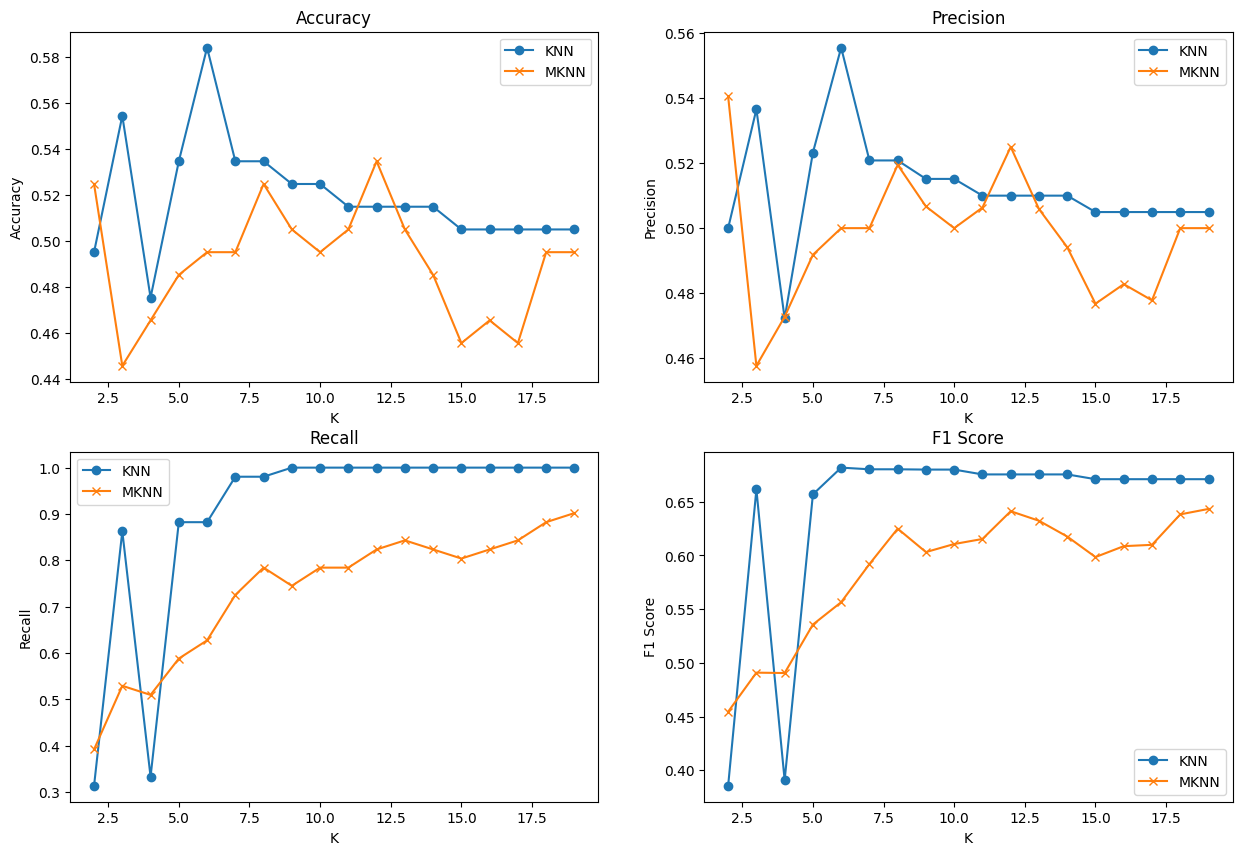

In [338]:
knn_acc_dict = dict(zip(ks, knn_accuracy_list))
knn_precision_dict = dict(zip(ks, knn_precision_list))
knn_recall_dict = dict(zip(ks, knn_recall_list))
knn_f1_score_dict = dict(zip(ks, knn_f1_score_list))

mknn_acc_dict = dict(zip(ks, mknn_accuracy_list))
mknn_precision_dict = dict(zip(ks, mknn_precision_list))
mknn_recall_dict = dict(zip(ks, mknn_recall_list))
mknn_f1_score_dict = dict(zip(ks, mknn_f1_score_list))


plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title("Accuracy")
plt.plot(knn_acc_dict.keys(), knn_acc_dict.values(), label="KNN", marker="o")
plt.plot(mknn_acc_dict.keys(), mknn_acc_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Precision")
plt.plot(knn_precision_dict.keys(),
         knn_precision_dict.values(), label="KNN", marker="o")
plt.plot(mknn_precision_dict.keys(),
         mknn_precision_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Recall")
plt.plot(knn_recall_dict.keys(), knn_recall_dict.values(),
         label="KNN", marker="o")
plt.plot(mknn_recall_dict.keys(), mknn_recall_dict.values(),
         label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("F1 Score")
plt.plot(knn_f1_score_dict.keys(),
         knn_f1_score_dict.values(), label="KNN", marker="o")
plt.plot(mknn_f1_score_dict.keys(),
         mknn_f1_score_dict.values(), label="MKNN", marker="x")
plt.xlabel("K")
plt.ylabel("F1 Score")
plt.legend()

plt.show()


In [339]:
knn_df = pd.DataFrame({
    "k": knn_acc_dict.keys(),
    "accuracy": knn_acc_dict.values(),
    "precision": knn_precision_dict.values(),
    "recall": knn_recall_dict.values(),
    "f1_score": knn_f1_score_dict.values(),
})

mknn_df = pd.DataFrame({
    "k": mknn_acc_dict.keys(),
    "accuracy": mknn_acc_dict.values(),
    "precision": mknn_precision_dict.values(),
    "recall": mknn_recall_dict.values(),
    "f1_score": mknn_f1_score_dict.values(),
})

In [343]:
knn_df.to_csv("./data/scores/2005_knn scores_1.csv", index=False)
mknn_df.to_csv("./data/scores/2005_mknn scores_1.csv", index=False)